### Imports

In [1]:
import pandas as pd
import numpy as np
import iexfinance as iex  #pip install iexfinance
from iexfinance.stocks import Stock
from datetime import datetime

import requests
import random
import time
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Content overview for workflow: 
#### Stock data from IEX or some other source? (https://www.quora.com/Using-Python-whats-the-best-way-to-get-stock-data)

1. Load in stock data (how much?)
    - Find a list/source for tickers, so we know which stocks to fetch -> https://iextrading.com/trading/eligible-symbols/
    - Get individual stocks from certain indicies? Or random subset from the ticker list?
    - Maybe get different industry indicies?
        - We need some form of sector/industry segmentation for the stocks
        - We need open, close, industry, sector, market cap ... ?
1. Basic summary statistics
    - Which stocks, how many in each segment, countries?,
    - Calculate returns... 
    - generate new variables that we need (may only be daily returns)
1. Plots for individual stocks
    - What does e.g. the price of  Apple, Danske Bank look like over time?
1. Interactive plot
    - A plot that shows weighted returns for our given subsample
    - Slider with time period (start, end)
    - Segmentation selection


### Remember to comment on code :)

## Data load-in (Waldemar?)

This sections loads in historical daily price data for stocks in the US using the *IEX* python module.

The goal is to calculate daily returns (simple and continuously compounded (cc)) for each stock - and visualize this information in the subsequent sections.

In [4]:
x=iex.refdata.get_symbols() #list of dicts with ticker symbols, names of all stocks in IEX database

df_ticker=pd.DataFrame(x) #To a dataframe
df_ticker.sample(5) #view of 5  random stocks

,date,iexId,isEnabled,name,symbol,type
5991,2019-03-22,15277,True,Pebblebrook Hotel Trust 6.375% Series E Cumula...,PEB-E,ps
6049,2019-03-22,15202,True,PennyMac Financial Services Inc.,PFSI,cs
1282,2019-03-22,1138,True,Celanese Corporation,CE,cs
7795,2019-03-22,10080,True,The Stars Group Inc.,TSG,cs
846,2019-03-22,14358,True,BioHiTech Global Inc.,BHTG,cs


In [5]:
df_ticker.loc[df_ticker['name'] == 'Apple Inc.']

,date,iexId,isEnabled,name,symbol,type
13,2019-03-22,11,True,Apple Inc.,AAPL,cs


In [6]:
tickers= list(df_ticker['symbol']) # tickers for 100 random stocks #.loc[df_ticker['isEnabled']==True] .sample(100, random_state=10)
tickers[0:5]

['A', 'AA', 'AAAU', 'AABA', 'AAC']

In [7]:
#Initing different containers for the first ticker

sector={} #empty dict for sectors for each ticker

stock=Stock(tickers[0])
sect=stock.get_book()['quote']['sector']
sector.update({tickers[0] : sect})

df_close=pd.DataFrame(iex.stocks.get_historical_data(tickers[0], start='2015-01-02', end='2019-01-02', output_format='pandas')['close'])
df_close=df_close.rename(columns = {'close' : tickers[0]})

In [ ]:
remove_stocks=[] #container for stocks that have tickers, but do not have historical data available

for i in tqdm(tickers[1:], leave=False): #runtime is ~3-4 hours?
    
    #Retrieving sector for each ticker
    try: 
        stock=Stock(i) #turning ticker i into iex.Stock object
        sect=stock.get_book()['quote']['sector'] #extracting sector from books
        sector.update({i : sect}) #appending to dict
    except:
        remove_stocks.append(i)
        
        
    #Creating df with close prices for each ticker
    try: 
        test=iex.stocks.get_historical_data(i, start='2015-01-02', end='2019-01-02', output_format='pandas')['close'] #returns a series
        test_df=pd.DataFrame(test)
        test_df=test_df.rename(columns = {'close' : i})
        
        #Final df with close prices with stock as a col
        df_close = pd.merge(df_close, test_df, how='left', left_index=True, right_index=True)
    except:
        remove_stocks.append(i)



  2%|▏         | 135/8721 [03:34<3:46:52,  1.59s/it]

In [8]:
#Turning SECTOR dict into series then dataframe:
x=pd.Series(sector)
df_sect=pd.DataFrame(x)
df_sect=df_sect.rename(columns={0 : 'sector'}) #renaming col

#Merging onto df_ticker
df_ticker=pd.merge(df_ticker, df_sect, how='left',  left_on=df_ticker['symbol'], right_index=True)

In [103]:
df_ticker.iloc[:20]

,date,iexId,isEnabled,name,symbol,type,sector
0,2019-03-18,2,True,Agilent Technologies Inc.,A,cs,Healthcare
1,2019-03-18,12042,True,Alcoa Corporation,AA,cs,Basic Materials
2,2019-03-18,14924,True,Perth Mint Physical Gold,AAAU,NaN,NaN
3,2019-03-18,7653,True,Altaba Inc.,AABA,cs,Financial Services
4,2019-03-18,9169,True,AAC Holdings Inc.,AAC,cs,Healthcare
5,2019-03-18,5,True,AdvisorShares Dorsey Wright ADR,AADR,et,NaN
6,2019-03-18,8148,True,American Airlines Group Inc.,AAL,cs,Industrials
7,2019-03-18,7760,True,Altisource Asset Management Corp Com,AAMC,cs,Financial Services
8,2019-03-18,7,True,Atlantic American Corporation,AAME,cs,Financial Services
9,2019-03-18,8,True,Aaron's Inc.,AAN,cs,Industrials


In [16]:
#exporting
#df_close.to_csv('df_close.csv', sep=';', index=True)
#df_ticker.to_csv('df_ticker.csv', sep=';', index=True)

## Data manipulation

In [3]:
df_close=pd.read_csv('df_close.csv', sep=';', index_col=0)
df_ticker=pd.read_csv('df_ticker.csv', sep=';', index_col=0)

In [4]:
#Simple returns dataframe
df_simple=df_close.copy().pct_change(1)

In [5]:
df_simple.tail()

,A,AA,AAAU,AABA,AAC,AADR,AAL,AAMC,AAME,AAN,...,ZUO,ZVV,ZVVV,ZVZZT,ZWZZT,ZXIET,ZXZZT,ZYME,ZYNE,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2018-12-26,0.045795,0.079125,-0.001553,0.039311,0.098684,0.036565,0.086473,0.127273,-0.055745,0.063211,...,0.088631,0.000000,NaN,-0.000997,0.000000,0.0,0.0,0.082130,-0.006803,0.000000
2018-12-27,0.014343,0.000737,0.006672,0.001209,-0.107784,-0.006026,-0.007742,0.021505,0.057564,-0.010226,...,0.005053,0.000000,NaN,0.000998,0.000000,0.0,0.0,-0.024187,0.010274,-0.022305
2018-12-28,-0.005368,-0.020619,0.003875,0.006555,-0.053691,0.010076,-0.006553,-0.002368,0.005570,0.010572,...,-0.013966,0.012048,NaN,-0.000997,0.000000,0.0,0.0,0.166667,-0.010169,0.007605
2018-12-31,0.022741,-0.000752,0.001649,-0.007027,-0.007092,0.002028,0.008796,-0.216829,0.010700,-0.000238,...,0.027762,0.000000,NaN,0.000000,-0.071429,0.0,0.0,0.075458,0.017123,0.109434
2019-01-02,-0.026238,-0.012792,0.017941,-0.007767,0.164286,0.006489,0.011523,0.010778,0.033753,0.034009,...,0.003308,0.000000,NaN,0.000000,0.000000,0.0,0.0,0.000681,0.252525,-0.017007


In [6]:
# cc returns dataframe
df_cc=df_simple.copy()
df_cc +=1
df_cc=df_cc.copy().apply(np.log)

In [7]:
df_cc.shape #days and number of stocks

(1007, 8683)

#### Prepare data for plots 

In [8]:
df_close_long = df_close.transpose() # transposing close data data 
df_close_long = pd.melt(df_close_long.reset_index() ,id_vars='index',var_name='date', value_name='return') # make data long for later use
df_close_long = df_close_long.merge(df_ticker[['symbol', 'name','sector']], how = 'left', left_on = 'index', right_on = 'symbol') # merging on sector
df_close_long['year'] = df_close_long['date'].astype(str).str[:4] # Create new column with the year
df_close_long = df_close_long.drop(columns=['index'])
df_close_long.tail()


,date,return,symbol,name,sector,year
8743776,2019-01-02,100.00,ZXIET,ZXIET Test Incorporated,NaN,2019
8743777,2019-01-02,42.89,ZXZZT,NASDAQ TEST STOCK,NaN,2019
8743778,2019-01-02,14.69,ZYME,Zymeworks Inc.,Healthcare,2019
8743779,2019-01-02,3.72,ZYNE,Zynerba Pharmaceuticals Inc.,Healthcare,2019
8743780,2019-01-02,2.89,ZYXI,Zynex Inc.,Healthcare,2019


In [9]:
df_simple_long = df_simple.transpose() # transposing return data 
df_simple_long = pd.melt(df_simple_long.reset_index() ,id_vars='index',var_name='date', value_name='return') # make data long for later use
df_simple_long = df_simple_long.merge(df_ticker[['symbol', 'name','sector']], how = 'left', left_on = 'index', right_on = 'symbol') # merging on sector
df_simple_long['year'] = df_simple_long['date'].astype(str).str[:4] # Create new column with the year
df_simple_long = df_simple_long.drop(columns=['index'])
df_simple_long.tail()

,date,return,symbol,name,sector,year
8743776,2019-01-02,0.000000,ZXIET,ZXIET Test Incorporated,NaN,2019
8743777,2019-01-02,0.000000,ZXZZT,NASDAQ TEST STOCK,NaN,2019
8743778,2019-01-02,0.000681,ZYME,Zymeworks Inc.,Healthcare,2019
8743779,2019-01-02,0.252525,ZYNE,Zynerba Pharmaceuticals Inc.,Healthcare,2019
8743780,2019-01-02,-0.017007,ZYXI,Zynex Inc.,Healthcare,2019


In [131]:
# save the data 

df_simple.to_csv('df_simple.csv', sep=';', index=True)
df_close_long.to_csv('df_close_long.csv', sep=';', index=True)
df_simple_long.to_csv('df_simple_long.csv', sep=';', index=True)

## Summary statistics (Mazzi?)

#### Simple daily returns and cc daily returns
simple returns: $R_t=\frac{P_t}{P_{t-1}}-1$

cc returns: $r_t=log\left(\frac{P_t}{P_{t-1}}\right)$

Whick implies: $r_t=log(1+R_t)$


Plot cc vs. simple to illustrate

In [10]:
# Number of symbols
print(df_ticker['symbol'].count()) # the data contains 8715 symbols

8715


In [11]:
# number of observations within each symbol
print(df_close_long.groupby('symbol')['symbol'].count()[:5]) # create a frequency table for symbols. We see that there is 1007 observations for each symbol


symbol
A       1007
AA      1007
AAAU    1007
AABA    1007
AAC     1007
Name: symbol, dtype: int64


## Descriptive plots (Sofie?)

#### Number of tickers by sector

sector
cryptocurrency              18
Communication Services     100
Utilities                  142
Consumer Defensive         219
Basic Materials            300
Energy                     314
Real Estate                459
Consumer Cyclical          603
Technology                 727
Industrials                794
Healthcare                 887
Financial Services        1539
Name: symbol, dtype: int64


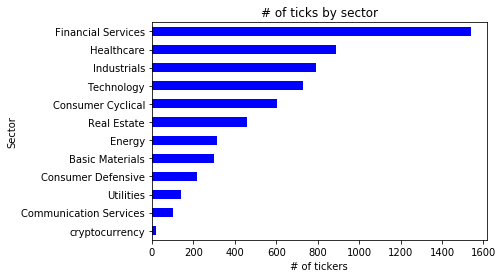

In [14]:
sector_freq = df_ticker.groupby('sector')['symbol'].count() # create a frequency table
sector_freq = sector_freq.sort_values(ascending=True) #sort the series 
print(sector_freq)
sector_freq.plot.barh(color = 'blue') # plotting the data
plt.xlabel('# of tickers')
plt.ylabel('Sector')
plt.title('# of ticks by sector')
plt.show()



#### Average simple return by sector

sector
Industrials                0.000220
Communication Services     0.000232
Real Estate                0.000239
Financial Services         0.000289
Utilities                  0.000324
Basic Materials            0.000448
Consumer Cyclical          0.001047
Healthcare                 0.003494
Energy                     0.034726
Technology                 2.868992
Consumer Defensive        15.985646
Name: return, dtype: float64


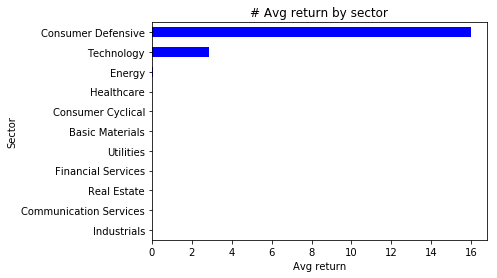

In [16]:
simple_return_sector = df_simple_long.groupby(['sector'])['return'].mean().sort_values(ascending=True)
print(simple_return_sector )
simple_return_sector.plot.barh( color = 'blue') # plotting the data
plt.xlabel('Avg return')
plt.ylabel('Sector')
plt.title('# Avg return by sector')
plt.show()

#### Average close return by sector

sector
Industrials                0.000220
Communication Services     0.000232
Real Estate                0.000239
Financial Services         0.000289
Utilities                  0.000324
Basic Materials            0.000448
Consumer Cyclical          0.001047
Healthcare                 0.003494
Energy                     0.034726
Technology                 2.868992
Consumer Defensive        15.985646
Name: return, dtype: float64


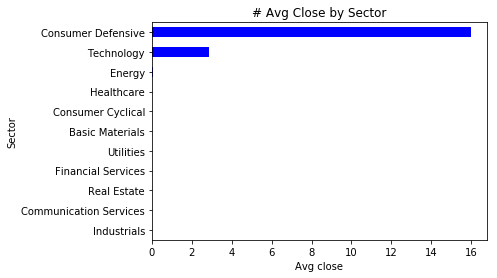

In [17]:
close_sector = df_simple_long.groupby(['sector'])['return'].mean().sort_values(ascending=True)
print(close_sector )
close_sector .plot.barh( color = 'blue') # plotting the data
plt.xlabel('Avg close')
plt.ylabel('Sector')
plt.title('# Avg Close by Sector')
plt.show()

#### Apples close in a given period

In [18]:
symbol = 'AAPL'
start_date = '2018-01-01'
end_date = '2019-01-01'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


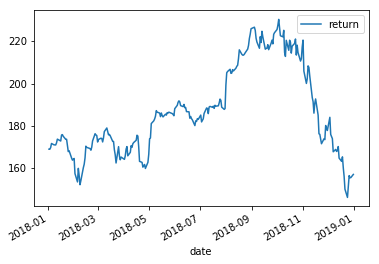

In [19]:
close_plot = df_close_long.loc[df_close_long['symbol'] == symbol]
close_plot['date'] = pd.to_datetime(close_plot['date'], format='%Y-%m-%d') # change variable to date
close_plot = close_plot.loc[df_close_long['date'] >= start_date]
close_plot = close_plot.loc[close_plot['date'] <= end_date]
close_plot.plot('date', 'return', kind = 'line')

## Interactive plot (Sofie + Waldemar?)

Need some installs: https://github.com/matplotlib/jupyter-matplotlib

`pip install ipympl`

`# If using JupyterLab`

`# Install nodejs: https://nodejs.org/en/download/`

`jupyter labextension install @jupyter-widgets/jupyterlab-manager`

`jupyter labextension install jupyter-matplotlib`


#### Content
1. Interactive plot with close price (from df_close) with slider for date, dropdown for ticker (multiple stock selection?)
1. Interactive plot with returns (either from df_simple or df_cc) with slider for date, dropdown for ticker
1. Interactive plot with indicies for sectors (need to create df) with slider for date, dropdown for sector (multiple selection allowed) ? (WALDEMAR)

In [117]:
import matplotlib.pyplot as plt
%matplotlib widget

#plt.figure()
#x = [1,2,3]
#y = [4,5,6]
#plt.plot(x,y)


plt.plot(df_close.sample(1, axis=1)) #Plotting random stock's closing price

FigureCanvasNbAgg()

### 

In [118]:
symbol = 'AAPL'
start_date = '2018-01-01'
end_date = '2018-03-01'
dataframe = df_close_long
I = (dataframe.date >= start_date) & (dataframe.date <= end_date) & (dataframe.symbol == symbol)
df_close_long['date'] = pd.to_datetime(df_close_long['date'], format='%Y-%m-%d') # change variable to date

In [168]:
def interactive_plot(dataframe, symbol):
    I = (dataframe.date >= start_date) & (dataframe.date <= end_date) & (dataframe.symbol == symbol)
    ax=dataframe.loc[I,:].plot(x='date', y='return', style='-o', legend='False')

In [120]:
import ipywidgets as widgets

In [121]:
widgets.interact(interactive_plot, 
                 dataframe = widgets.fixed(df_close_long),
                 symbol = widgets.Dropdown(description='symbol', options=df_ticker.symbol.unique(), value='AAPL')
); 

FigureCanvasNbAgg()

In [122]:
dataframe.loc[I,:].plot('date', 'return', kind = 'line')

FigureCanvasNbAgg()